In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sys import path
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/PHI/ToF_ML/src

/content/drive/MyDrive/PHI/ToF_ML/src


In [4]:
from data_generator import DataGenerator

In [5]:
norm_data = pd.read_csv('../data/all_calibrated_data.csv')

In [6]:
from ast import literal_eval
norm_data['channels']  = norm_data['precise_channels'].apply(literal_eval)
norm_data['intensities'] = norm_data['precise_intensities'].apply(literal_eval)
norm_data.drop(['precise_channels', 'precise_intensities'], axis=1, inplace=True)

In [7]:
norm_data.dropna(inplace=True)
norm_data = norm_data[norm_data['intensities'].apply(len)> 0].copy()

In [12]:
from data_transformation import get_frags

In [13]:
frags = get_frags()

In [14]:
frags.head()

,FragmentMass,FragmentLabel,Isotopes,Formula,FragmentID
0,1.007820,H,1H1,H,1
1,2.014100,H,2H1,2H,2
2,3.016029,He,3He1,3He,3
3,4.002603,He,4He1,He,4
4,6.015120,Li,6Li1,6Li,5


In [15]:
from data_transformation import mass_formula

In [16]:
spots = frags['FragmentMass']

In [17]:
def get_frags_dists(masses, frags, thresh=0.005, ab=True):
    '''
    Determines which elemental / compound masses correspond
    to actual spectra masses and returns both the fragments
    and the distance between each fragment and its related mass in
    the given spectra.
    '''
    found_masses = []
    found_frags = []
    dists = []
    for mass in masses:
        not_found = True
        i = (len(frags)) // 2
        floor = 0
        cieling = len(frags) - 1

        def is_findable():
            if abs(floor - cieling) <= 1:
                return False
            return True
        
        while not_found:
            dist = frags[i] - mass
            if abs(dist) < thresh:
                not_found = False
                i = get_closest(i, frags, mass)
                found_masses.append(mass)
                found_frags.append(frags[i])
                if ab:
                    dists.append(abs(frags[i] - mass))
                else:
                    dists.append((frags[i] - mass))
            elif dist > 0:
                not_found = is_findable()
                cieling = i
                num = abs(floor - i)
                if num != 1:
                    i -= abs(floor - i) // 2
                else:
                    i -= 1
            else:
                not_found = is_findable()
                floor = i
                num = abs(cieling - i)
                if num != 1:
                    i += abs(cieling - i) // 2
                else:
                    i += 1
    return found_masses, found_frags, dists

In [18]:
def get_closest(i, frags, mass):
    d = abs(frags[i] - mass)
    if len(frags) > i + 1 and d > abs(frags[i + 1] - mass):
        i = get_closest(i + 1, frags, mass)
    elif i - 1 >= 0 and d > abs(frags[i - 1] - mass):
        i = get_closest(i - 1, frags, mass)
    return i

In [20]:
dg = DataGenerator(norm_data)
original_data = dg.calibrated_df(slope_index=2)

In [42]:
from data_transformation import generate_data, mass_formula, generate_calibrated_data
erred = generate_data(dg.df(), 2, 2, [0, 0, 0], slope_index=2)
for num in range(1):
    for _ in range(1):
        erred = pd.concat([erred, generate_data(dg.df(), num + 3, 2, [0.25, .5, 1], True, True, slope_index=2)], axis=0)
erred.reset_index(inplace=True, drop=True)
erred = generate_calibrated_data(erred, slope_index=2)

In [43]:
from data_transformation import get_fragment_stats
erred = get_fragment_stats(erred)

In [44]:
erred.head()

,file_name,Mass/Time,MassOffset,StartFlightTime,SpecBinSize,channels,intensities,target,err_prop_slope,err_prop_offset,masses,avg_dist_frags_low,avg_dist_frags_high,adjusted_proportion_identified,proportion_identified,diff,prop_diff_in_low,calibration
0,0106301.cas,0.387425,-0.275047,0.0,1.248,"[2644.0367300000003, 3505.0183700000002, 4162....","[73874, 1234, 138, 610, 1216, 4159, 8958, 1084...",0,0.0,0.0,"[1.0067357827001502, 2.0154136848060986, 3.019...",0.001210,0.002547,0.418033,0.398438,0.001337,1.105054,0
1,0107316.cas,0.387337,-0.278302,0.0,1.248,"[2647.00072, 3508.9949100000003, 4164.59326000...","[49864, 1034, 168, 4696, 8247, 13992, 17903, 2...",0,0.0,0.0,"[1.0025002148906825, 2.0105384152423085, 3.009...",0.001230,0.002755,0.131783,0.129771,0.001525,1.239977,0
2,0110203.cas,0.378938,-0.271015,0.0,4.992,"[1973.87665, 2049.0706800000003, 2122.01224, 2...","[23352, 74717, 10387, 947, 12344, 9121, 249, 4...",0,0.0,0.0,"[11.9915465622805, 12.996908473240481, 14.0108...",0.001164,0.002964,0.388889,0.388889,0.001800,1.545688,0
3,0110212.cas,0.379297,-0.269824,0.0,4.992,"[672.00298, 891.90543, 1970.94521, 2046.11295,...","[34398, 304, 2223, 3521, 5205, 6509, 99, 115, ...",0,0.0,0.0,"[1.0051638174978792, 2.0134261084051888, 11.98...",0.001326,0.002605,0.379630,0.379630,0.001279,0.964176,0
4,0116511.cas,0.383481,-0.302161,0.0,1.248,"[2726.98153, 3594.53649, 4265.28736, 7866.5038...","[42995, 602, 151, 17912, 9536, 17609, 29604, 5...",0,0.0,0.0,"[1.0058658675679875, 2.011083088854326, 3.0245...",0.001521,0.003114,0.418367,0.336066,0.001593,1.047139,0


In [45]:
from data_transformation import mass_formula
def get_cols(data, amt, err=False):
    n = 1
    if err:
        n = 3
    cols = [[[] for num in range(n)] for num in range(2)]
    for row in data.itertuples():
        mass_lists = [row.masses]
        if err:
            for num in [1, -1]:
                x = pd.Series(row.channels)
                y = x.apply(mass_formula, args=(row.SpecBinSize,
                                            row.StartFlightTime,
                                            row[2],
                                            row.MassOffset + num * row.MassOffset * amt))
                mass_lists.append(y)
        for i in range(n):
            a, b,  = get_stats(mass_lists[i])
            cols[0][i].append(a) # proportion labeled
            if b != 0:
                cols[1][i].append(b)
            else:
                cols[1][i].append(0)
    return cols

In [46]:
def get_stats(row_masses):
    masses, _, distances1 = get_frags_dists(row_masses, spots, thresh=0.003)
    _, _, distances2 = get_frags_dists(row_masses, spots, thresh=0.007)
    x = 0
    if len(distances1) > 0:
        x = np.mean(distances1)
    y = 0
    if len(distances2) > 0:
        y = np.mean(distances2)
    return len(masses) / len(np.array(row_masses)[np.array(row_masses) < 236]), y

In [47]:
cols = get_cols(erred, .004, err=True)

In [48]:
from sklearn.model_selection import train_test_split
d = { 'Miscalibrated': erred['target'],'Proportion Assigned': cols[0][0], 'Distance From Fragment': cols[1][0], 'Proportion w/ Offset Added': cols[0][1], 'Distance w/ Offset Added': cols[1][1], 'Proportion w/ Offset Subbed': cols[0][2], 'Distance w/ Offset Subbed': cols[1][2]}
training_data = pd.DataFrame(d)

In [49]:
training_data.tail()

,Miscalibrated,Proportion Assigned,Distance From Fragment,Proportion w/ Offset Added,Distance w/ Offset Added,Proportion w/ Offset Subbed,Distance w/ Offset Subbed
2869,1,0.733871,0.001395,0.310484,0.002798,0.358871,0.002527
2870,1,0.125641,0.002628,0.105128,0.002797,0.143590,0.002615
2871,1,0.241422,0.002292,0.222494,0.002410,0.087010,0.002566
2872,2,0.116959,0.003448,0.000000,0.000000,0.385965,0.002508
2873,1,0.165517,0.002603,0.151724,0.002794,0.103448,0.003740


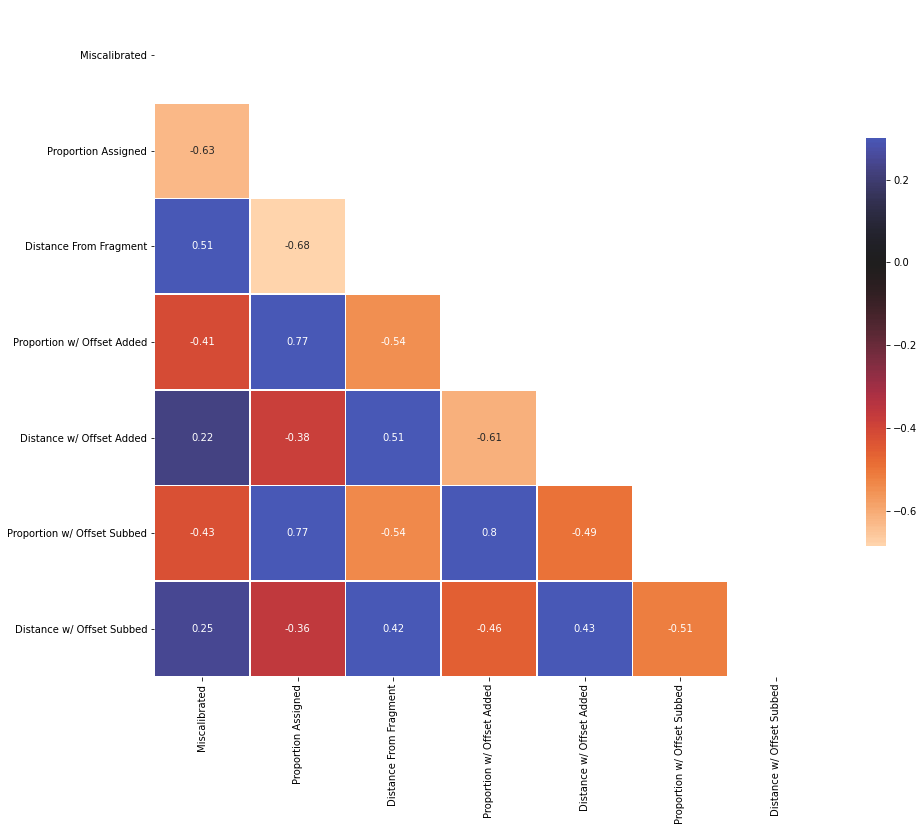

In [50]:
corr_df = training_data.copy()
corr = corr_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(15, 15))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, cmap='icefire_r',mask=mask, vmax=.3, center=0,
            square=True, linewidths=.5, annot=True, ax=ax, cbar_kws={"shrink": 0.5})
corr_df=None

In [51]:
X = training_data
y = erred['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
rfc = RandomForestClassifier(class_weight={0:1, 1:1})
parameters = {'criterion':('gini', 'entropy'), 'n_estimators':[75, 150], 'max_depth':[3, 31]}
clf = GridSearchCV(rfc, parameters)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

1.0

In [53]:
clf.score(X_train, y_train)

1.0

In [54]:
wrong = X_test.loc[y_test!= clf.predict(X_test)].copy()
wrong['target'] = y_test[y_test!= clf.predict(X_test)]
wrong.head()

,Miscalibrated,Proportion Assigned,Distance From Fragment,Proportion w/ Offset Added,Distance w/ Offset Added,Proportion w/ Offset Subbed,Distance w/ Offset Subbed,target


In [56]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier(boosting_type ='goss', class_weight={0:1, 1:1})
parameters = {'num_leaves':[3,31], 'max_depth':[-1, 10], 'learning_rate':[0.001, 0.5], 'n_estimators':[75, 150]}
clf = GridSearchCV(lgbm, parameters)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

1.0

In [57]:
clf.score(X_train, y_train)

1.0

In [ ]:
erred = original_data[original_data['calibration']==1].copy()
df = generate_data(original_data, 2, 2, True, [0, 0, 1], True, True, slope_index=2).drop(['err_prop_offset', 'err_prop_slope'], axis=1)
df['target'] = 1
erred = pd.concat([erred, df], axis=0)
dg.set_df(erred)
erred = dg.calibrated_df(slope_index=2)
erred.reset_index(drop=True, inplace=True)
isotopes = get_isotope_data()
ranges = get_ranges(isotopes['Isotope Masses'], 2000)
erred['num_peaks_nml'] = erred['masses'].apply(get_suspicious_peaks, args=(ranges,)).apply(len)
erred['num_peaks_not_nml'] = erred['masses'].apply(len) - erred['num_peaks_nml']
erred['prop_peaks_nml'] = erred['num_peaks_nml'] / erred['masses'].apply(len)

ValueError: ignored

In [ ]:
cols = get_cols(erred, .1, True)
d = {'num_norm': cols[0][0], 'prop_norm': cols[1][0],'diff_low_norm': cols[2][0],'diff_high_norm': cols[3][0], 'num_add':cols[0][1], 'prop_add':cols[1][1], 'diff_low_add':cols[2][1], 'diff_high_add':cols[3][1], 'num_sub': cols[0][2], 'prop_sub':cols[1][2], 'diff_low_sub':cols[2][2], 'diff_high_sub':cols[3][2]}
training_data = pd.DataFrame(d)
training_data['num_peaks_nml'] = erred['num_peaks_nml']
training_data['num_peaks_not_nml'] = erred['num_peaks_not_nml']

In [ ]:
X = training_data
y = erred['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
lgbm = LGBMClassifier(boosting_type ='goss', class_weight={0:4, 1:1})
parameters = {'num_leaves':[3,31], 'max_depth':[-1, 10], 'learning_rate':[0.001, 0.5], 'n_estimators':[75, 150]}
clf = GridSearchCV(lgbm, parameters)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

/Users/warren/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

0.8461538461538461

In [ ]:
inds = y_test.reset_index().loc[np.where(np.array(y_test) != clf.predict(X_test))]['index']

In [ ]:
wrong = erred.loc[inds].copy()
wrong

In [ ]:
np.mean(wrong[wrong['target']==0]['diff'])

0.00039551355417417964

In [ ]:
erred = original_data[original_data['calibration']==1].copy()
df = generate_data(original_data, 1, 1, True, [0, 0, 1], True, True).drop(['err_prop_offset', 'err_prop_slope'], axis=1)
df['target'] = 1
erred = pd.concat([erred, df.sample(190)], axis=0)
dg.set_df(erred)
erred = dg.calibrated_df()
erred.reset_index(drop=True, inplace=True)
isotopes = get_isotope_data()
ranges = get_ranges(isotopes['Isotope Masses'], 2000)
erred['num_peaks_nml'] = erred['masses'].apply(get_suspicious_peaks, args=(ranges,)).apply(len)
erred['num_peaks_not_nml'] = erred['masses'].apply(len) - erred['num_peaks_nml']
erred['prop_peaks_nml'] = erred['num_peaks_nml'] / erred['masses'].apply(len)

In [ ]:
cols = get_cols(erred, .1, True)
d = {'num_norm': cols[0][0], 'prop_norm': cols[1][0],'diff_low_norm': cols[2][0],'diff_high_norm': cols[3][0], 'num_add':cols[0][1], 'prop_add':cols[1][1], 'diff_low_add':cols[2][1], 'diff_high_add':cols[3][1], 'num_sub': cols[0][2], 'prop_sub':cols[1][2], 'diff_low_sub':cols[2][2], 'diff_high_sub':cols[3][2]}
training_data = pd.DataFrame(d)
training_data['num_peaks_nml'] = erred['num_peaks_nml']
training_data['num_peaks_not_nml'] = erred['num_peaks_not_nml']

In [ ]:
X = training_data
y = erred['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
lgbm = LGBMClassifier(boosting_type ='goss', class_weight={0:1, 1:1})
parameters = {'num_leaves':[3,31], 'max_depth':[-1, 10], 'learning_rate':[0.001, 0.5], 'n_estimators':[75, 150]}
clf = GridSearchCV(lgbm, parameters)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

/Users/warren/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

/Users/warren/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.8974358974358975

In [ ]:
inds = y_test.reset_index().loc[np.where(np.array(y_test) != clf.predict(X_test))]['index']
wrong = erred.loc[inds].copy()

In [ ]:
wrong

,precise_channels,precise_intensities,file_name,Mass/Time,MassOffset,StartFlightTime,SpecBinSize,channels,peaks,mass_channels,...,avg_dist_frags_low_thresh,avg_dist_frags_high_thresh,num_indentified_frags,proportions_peaks_identified,diff,calibration,target,num_peaks_nml,num_peaks_not_nml,prop_peaks_nml
336,0 19315.62211 1 27318.48778 2 6...,0 1662 1 99 2 1124 3 2695 4 ...,CHB66PC.cas,0.376574,-0.000080,0.0,0.138,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[(19315.62211, 1662), (27318.48778, 99), (6665...","[19315.62211, 27318.48778, 66656.90577, 69400....",...,0.001281,0.002175,56,0.615385,0.000894,0,1,0,91,0.000000
196,0 19109.53083 1 27026.01346 2 ...,0 9461 1 370 2 96 3 182...,CHB23PE.cas,0.380672,-0.000006,0.0,0.138,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[(19109.53083, 9461), (27026.013460000002, 370...","[19109.53083, 27026.013460000002, 33098.04043,...",...,0.001165,0.001971,160,0.642570,0.000806,0,1,0,249,0.000000
282,0 27299.06012 1 33434.63398 2 ...,0 597 1 157 2 1099 3 248...,CHB105PD.cas,0.376843,0.000003,0.0,0.138,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[(27299.06012, 597), (33434.63398, 157), (6660...","[27299.06012, 33434.63398, 66605.55182000001, ...",...,0.001169,0.001795,80,0.747664,0.000627,0,1,0,107,0.000000
380,0 27120.58133 1 33216.76022 2 ...,0 706 1 105 2 413 3 127...,CHC18PC.cas,0.379315,-0.000036,0.0,0.138,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[(27120.58133, 706), (33216.76022, 105), (6617...","[27120.58133, 33216.76022, 66175.47034, 68898....",...,0.001257,0.001900,139,0.586498,0.000642,0,1,0,237,0.000000
246,0 27294.00977 1 33428.93444 2 6...,0 654 1 200 2 331 3 1041 4 ...,CHB121PD.cas,0.376969,-0.000093,0.0,0.138,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[(27294.00977, 654), (33428.93444, 200), (6658...","[27294.00977, 33428.93444, 66588.36959, 69327....",...,0.001288,0.001982,55,0.696203,0.000694,0,1,0,79,0.000000
382,0 27300.80038 1 33438.03078 2 ...,0 988 1 219 2 602 3 ...,CHB149PD.cas,0.376801,0.000060,0.0,0.138,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[(27300.80038, 988), (33438.03078, 219), (6661...","[27300.80038, 33438.03078, 66616.58242, 69357....",...,0.001285,0.001834,147,0.639130,0.000549,1,1,0,230,0.000000
94,0 19308.49515 1 72025.84623 2 ...,0 570 1 208 2 562 3 ...,CHB92PE.cas,0.376640,0.000040,0.0,0.138,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[(19308.49515, 570), (72025.84623, 208), (7456...","[19308.49515, 72025.84623, 74569.74406, 92246....",...,0.001029,0.001415,69,0.552000,0.000387,1,0,16,109,0.128000
137,0 27020.13631 1 33093.84629 2 ...,0 709 1 162 2 768 3 ...,CHC33PA.cas,0.380718,0.000040,0.0,0.138,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[(27020.13631, 709), (33093.846289999994, 162)...","[27020.13631, 33093.846289999994, 65931.91798,...",...,0.000980,0.001363,184,0.564417,0.000383,1,0,11,315,0.033742


# Takeaways:

+ Matching fragments to peaks is an effective way to attempt to measure a spectras calibration
+ Some spectra we have are far more calibrated than others
+ Our alogirthm has trouble with certain calibrated spectrum that look uncalibrated
    + we must decide whether this data is actually calibrated or not
+ Our algorithm has trouble with certain uncalibrated spectrum that look calibrated
    + if an offset errored spectrum looks like a calibrated spectrum, is it calibrated?